# Modeling Extremes - Numpyro Pt 2 - MAP

In [126]:
import pandas as pd
from scipy.stats import genextreme
import numpy as np
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import numpyro
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import jax
import jax.random as jrandom
import jax.numpy as jnp
from jaxtyping import Array, Float
from tensorflow_probability.substrates.jax import distributions as tfd
import xarray as xr
import regionmask
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [2]:
# data_url = "/pool/datos/reanalisis/era5/daily/spain/025/t2max/*.nc"
data_url = "/pool/datos/reanalisis/era5/anomaly/spain/025/t2max/*.nc"
ds = xr.open_mfdataset(data_url)

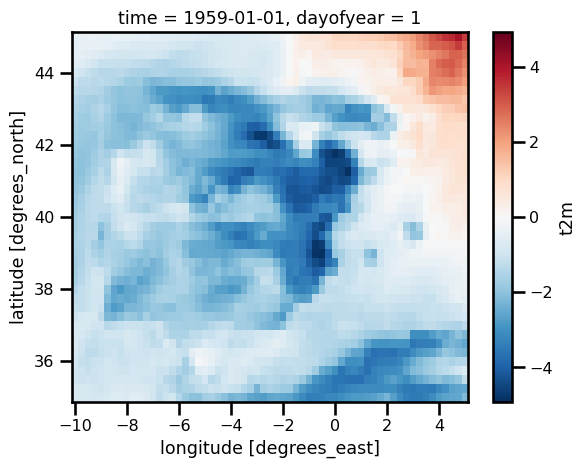

In [3]:
ds.t2m.isel(time=0).plot.pcolormesh()

## Masking

In [4]:
# get countries mask
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
# create mask variable
mask = countries.mask_3D(ds)
# select Spain mask
spain_mask = mask.isel(region=(mask.names=="Spain")).squeeze()

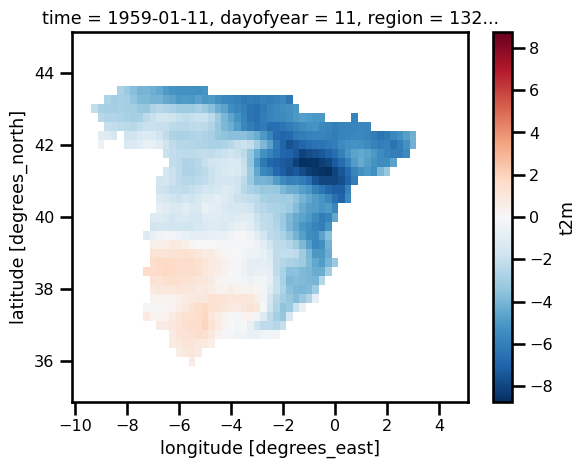

In [5]:
ds.where(spain_mask.squeeze()).isel(time=10).t2m.plot()

In [6]:
# get land-sea-mask mask
land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
# create land mask variable
land_mask = land_110.mask_3D(ds)

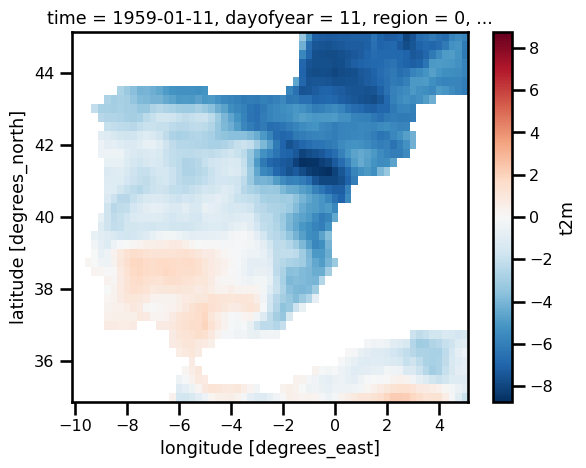

In [7]:
ds.where(land_mask.squeeze()).isel(time=10).t2m.plot()

## Clean Data

* Take Weighted Mean
* Convert Kelvin to Celsius
* Convert to DataFrame & Series
* Drop NANS
* Sort according to time
* Small Correction to Date

In [8]:
# # take weighted spatial mean
# import numpy as np
# weights = spain_mask.squeeze() * np.cos(np.deg2rad(ds.latitude))
# ds = xr.open_mfdataset(data_url)
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"]) - 272.15

### Region Selection

We are going to select Spain but also perhaps Madrid.

In [9]:
# # take weighted spatial mean
# weights = spain_mask * np.cos(np.deg2rad(ds.latitude))
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"])

# select MADRID region
data = ds.sel(longitude=-3.703790, latitude=40.416775, method="nearest")

In [10]:

# # convert Kelvin to Celcius
# data -= 272.15
# convert to dataframe
data = data.t2m.to_dataframe()
# create time series
data = pd.Series(data["t2m"])
# remove nans
data = data.dropna()
# sort ascending
data = data.sort_index(ascending=True)
# # start time
t0 = data.index[0]
# # rescale time
data = data - (data.index.array - pd.to_datetime(t0.year)) / pd.to_timedelta("365.2425D") * 2.87e-3
data.describe()

count    23011.000000
mean        -0.382247
std          3.740105
min        -16.210242
25%         -2.915719
50%         -0.283981
75%          2.215052
max         12.947272
Name: t2m, dtype: float64

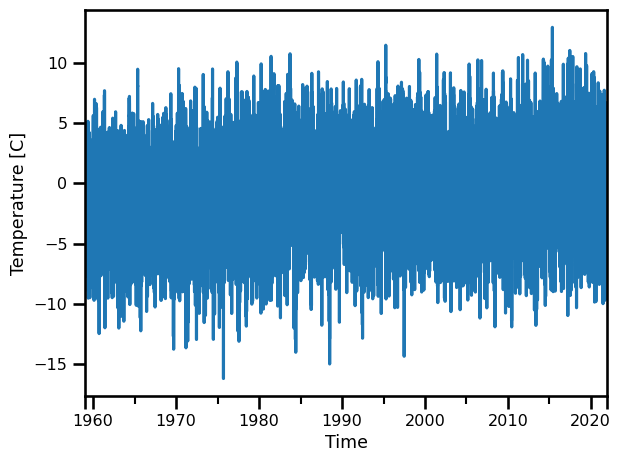

In [11]:
fig, ax = plt.subplots()

data.plot(ax=ax)

ax.set(
    xlabel="Time",
    ylabel="Temperature [C]"
)
plt.tight_layout()
plt.show()

## Extremes

In [12]:
extremes_method = "BM"
block_size = f"{3*30}D" # "365.2425D" # 
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

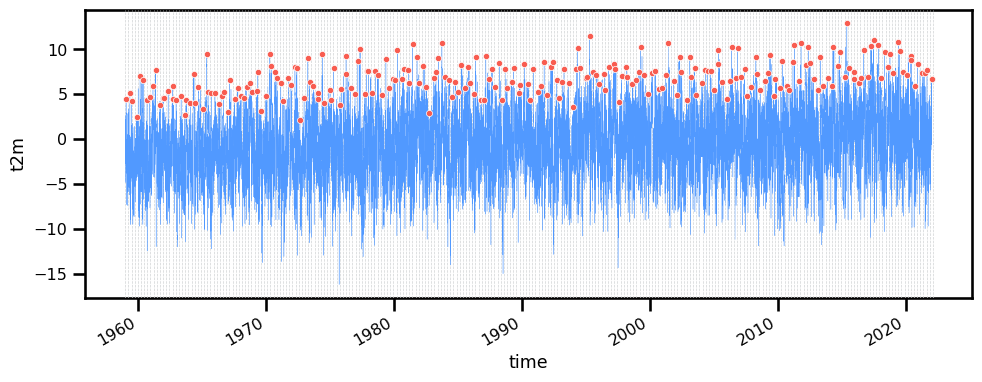

In [13]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

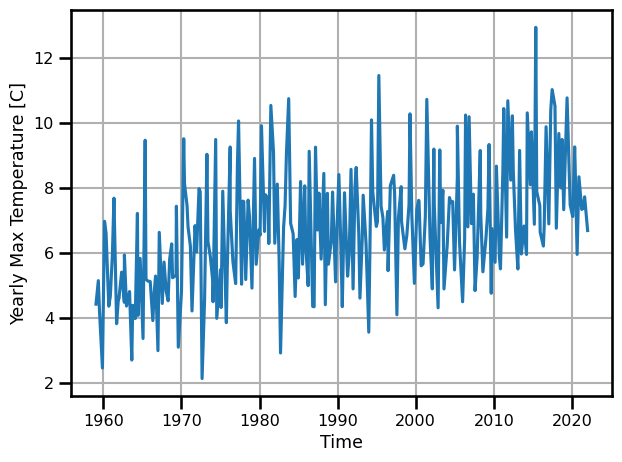

In [14]:
fig, ax = plt.subplots()

ax.plot(extremes)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]"
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.show()

## Model

We factoized the **Joint Distribution** as so:

$$
p(y,\boldsymbol{\theta}) = p(\boldsymbol{\theta})\prod_{n=1}^N p(y_n|\boldsymbol{\theta})
$$

### Prior & Likelihood

We do a uniform prior for the parameters.

$$
p(\boldsymbol{\theta}) = U(-\infty, \infty)
$$

We use the GEVD for the likelihood.

$$
p(y) \sim \text{GEVD}(\boldsymbol{\theta})
$$

where $\boldsymbol{\theta}=\{\mu,\sigma,\xi\}$ are the location, scale and shape parameters.

In [15]:


def model(y: Float[Array, "N"]=None):
    # prior parameters
    loc = numpyro.sample("loc", dist.Normal(0.0, 5.0))
    scale = numpyro.sample("scale", dist.LogNormal(0.0, 10.0))
    concentration = numpyro.sample("concentration", dist.LogNormal(loc=0.0, scale=2.0))
    
    # likelihood
    numpyro.sample("obs", tfd.GeneralizedExtremeValue(loc, scale, concentration), obs=y)

In [16]:
rng_key = jrandom.PRNGKey(123)

### Variational Distribution

In [17]:
from numpyro.infer.autoguide import AutoDelta

guide = AutoDelta(model)

### Inference

$$
\boldsymbol{\phi}^* = 
\underset{\boldsymbol{\phi}}{\text{argmin}}
\hspace{2mm}
\text{ELBO}_{q}
\left[q(\boldsymbol{\theta};\boldsymbol{\phi}), p(y,\boldsymbol{\theta})\right]
$$

In [18]:
from numpyro.infer import Predictive, SVI, Trace_ELBO
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [19]:
num_steps = 3_000
y = extremes.values
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

svi_result = svi.run(rng_key=rng_key_train, num_steps=num_steps, y=y)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2593.17it/s, init loss: 1007.8817, avg. loss [2851-3000]: 544.6614]


### Training

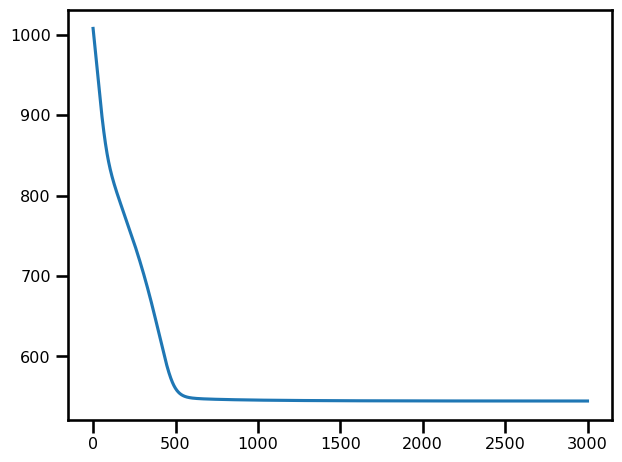

In [20]:
fig, ax = plt.subplots()
ax.plot(svi_result.losses)
plt.tight_layout()
plt.show()

### Params

In [21]:
svi_result.params

{'concentration_auto_loc': Array(0.00508041, dtype=float32),
 'loc_auto_loc': Array(5.869708, dtype=float32),
 'scale_auto_loc': Array(1.7607605, dtype=float32)}

We notice that these variable names are not the same as the names we prescribed. 
This is because these are the parameters of the variational distribution, **not** the model.
So we need to do some extra to be able to get the proper parameters.

We can use the `Predictive` inference helper from the `numpyro` library.
In this case, we only need 1 sample because we have a simple guide.

In [22]:
params = svi_result.params
# samples = guide.get_posterior(params)
predictive = Predictive(guide, params=params, num_samples=1)
posterior_samples = predictive(jrandom.PRNGKey(0), return_sites=["concentration"])
posterior_samples

{'concentration': Array([0.00508041], dtype=float32),
 'loc': Array([5.869708], dtype=float32),
 'scale': Array([1.7607605], dtype=float32)}

Now, we can extract the true parameters.

In [23]:
c = posterior_samples["concentration"][0]
loc = posterior_samples["loc"][0]
scale = posterior_samples["scale"][0]

In [34]:
print("Parameters (MAP):")
print(f"Shape - ξ: {c:.4f}")
print(f"Loc   - μ: {loc:.4f}")
print(f"Scale - σ: {scale:.4f}")

Parameters (MAP):
Shape - ξ: 0.0051
Loc   - μ: 5.8697
Scale - σ: 1.7608


## Return Period

In [103]:
def safe_reciprocal(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x, float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / x[~near_zero]
    return x

In [104]:
import numpy as np
from scipy.stats import genextreme

return_periods = np.logspace(-0.9999, 2, 100)

model = tfd.GeneralizedExtremeValue(loc=loc, scale=scale, concentration=c)
return_levels = model.quantile(1-safe_reciprocal(return_periods))

In [105]:
return_levels

Array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,  2.065163 ,  4.128436 ,
        4.61897  ,  4.9720597,  5.2627153,  5.516775 ,  5.7465215,
        5.9588485,  6.158047 ,  6.346987 ,  6.5276885,  6.7016335,
        6.8699436,  7.0334888,  7.19296  ,  7.3489137,  7.5018067,
        7.6520185,  7.799867 ,  7.9456215,  8.089514 ,  8.231741 ,
        8.372478 ,  8.511872 ,  8.650059 ,  8.787153 ,  8.923259 ,
        9.058468 ,  9.192862 ,  9.326515 ,  9.459494 ,  9.591856 ,
        9.723658 ,  9.854947 ,  9.985768 , 10.116162 , 10.246163 ,
       10.375809 , 10.505126 , 10.634145 , 10.76289  , 10.8913

In [153]:
def plot_return_period(
    return_periods,
    return_levels,
    label: str="Model"
):
    fig, ax = plt.subplots(figsize=(6,6))

    ax.plot(
        return_periods, return_levels, 
        linestyle="--", linewidth=3, color="tab:red",
        label=label,
    )
    ax.set(
        xlabel="Return Period [years]",
        ylabel="Return Levels (Anomalies) [°C]",
        xscale="log",
        xlim=[1.0, 100]
    )

    # format log scale labels
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    ax.xaxis.set_major_formatter(formatter)

    # SECOND AXIS
    secax = ax.secondary_xaxis("top")
    secax.set_xlabel("Probability")
    secax.set_xscale("log")
    xticks = [10, 100]
    secax.set_xticks(xticks)
    formatter = FuncFormatter(lambda x, pos: f"{safe_reciprocal(x)}")
    secax.xaxis.set_major_formatter(formatter)


    plt.grid(which="both", visible=True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return fig, ax
    

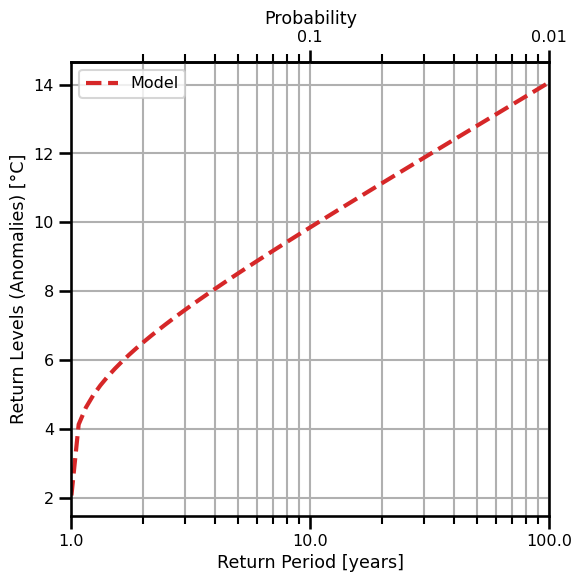

In [155]:
plot_return_period(
    return_levels=return_levels, 
    return_periods=return_periods,
);

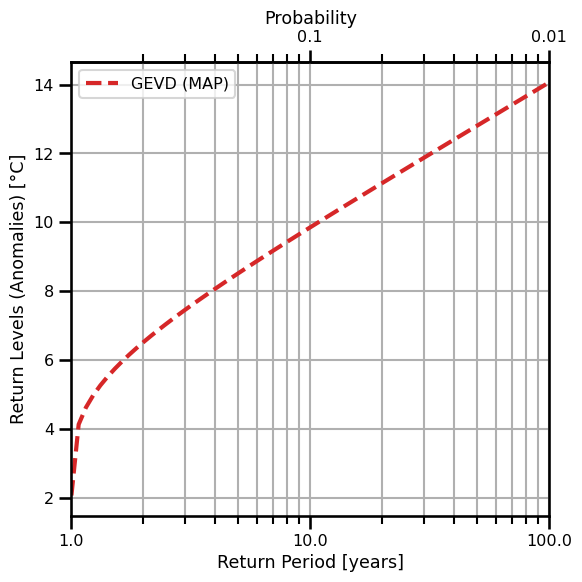

In [151]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    return_periods, return_levels, 
    linestyle="--", linewidth=3, color="tab:red",
    label="GEVD (MAP)",
)

ax.set(
    xlabel="Return Period [years]",
    ylabel="Return Levels (Anomalies) [°C]",
    xscale="log",
    xlim=[1.0, 100]
)





# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)


# SECOND AXIS
secax = ax.secondary_xaxis("top")
secax.set_xlabel("Probability")
secax.set_xscale("log")
xticks = [10, 100]
secax.set_xticks(xticks)
formatter = FuncFormatter(lambda x, pos: f"{safe_reciprocal(x)}")
secax.xaxis.set_major_formatter(formatter)


plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()